<a href="https://colab.research.google.com/github/WELLMAX357/dogs_vs_cats/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

'''setting seed'''
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip
# !unzip dogs-vs-cats-redux-kernels-edition
# !unzip train.zip
# !unzip test.zip

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes
 98% 799M/812M [00:05<00:00, 194MB/s]
100% 812M/812M [00:05<00:00, 152MB/s]
Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("/content/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [ ]:
TRAIN_DIR_PATH = '/content/train'
file_names = os.listdir(TRAIN_DIR_PATH)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 25000 number of images in directory.


In [ ]:
def to_dataframe(file_names):
    files, labels = list(), list()
    for file in file_names:
        files.append(file)
        labels.append(file[:3])
    df = pd.DataFrame({'filename':files, 'label':labels})
    return df

df = to_dataframe(file_names)

In [ ]:
df.head()

,filename,label
0,cat.10600.jpg,cat
1,cat.6545.jpg,cat
2,cat.9254.jpg,cat
3,dog.7384.jpg,dog
4,cat.2704.jpg,cat


data set label distribution:
 cat    12500
dog    12500
Name: label, dtype: int64


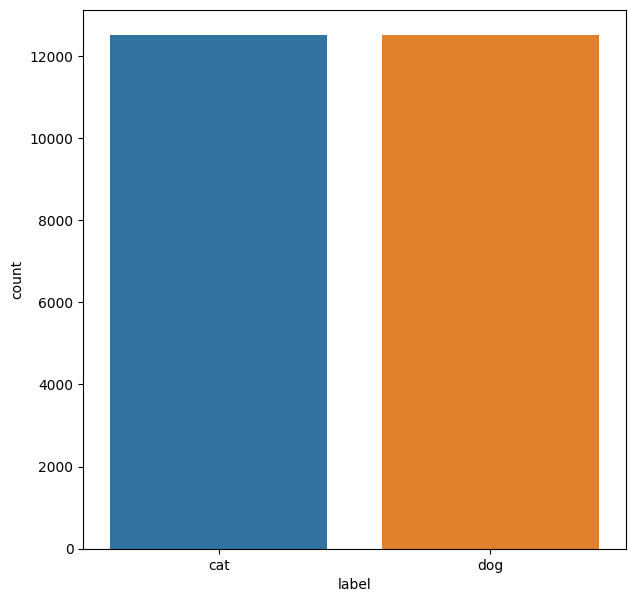

In [ ]:
print('data set label distribution:\n',df['label'].value_counts())

plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.show()

In [ ]:
cat = [file for file in file_names if file[:3]=='cat']
dog = [file for file in file_names if file[:3]=='dog']

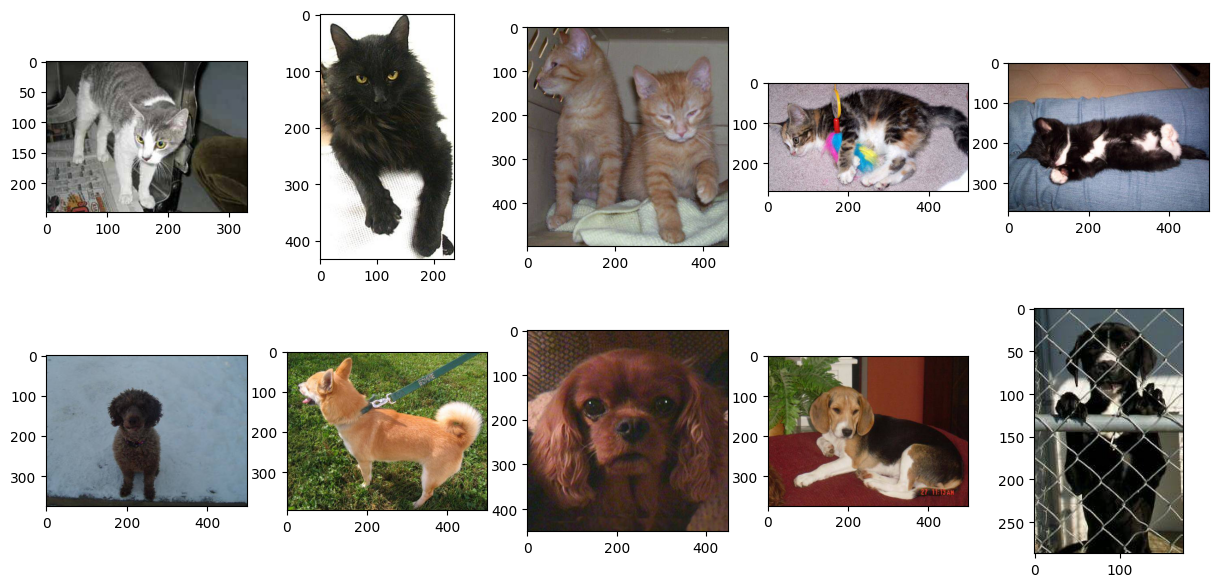

In [ ]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.random.randint(0,len(cat),5), start=1):
    im = img.imread('/content/train/'+cat[c])
    plt.subplot(2,5,i)
    plt.imshow(im)

for i, c in enumerate(np.random.randint(0,len(dog),5), start=6):
    im = img.imread('/content/train/'+dog[c])
    plt.subplot(2,5,i)
    plt.imshow(im)

In [ ]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(df, test_size=0.2,random_state=seed)

In [ ]:
train_set.shape, valid_set.shape

((20000, 2), (5000, 2))

train set distribution:
 dog    10039
cat     9961
Name: label, dtype: int64

valid set distribution:
 cat    2539
dog    2461
Name: label, dtype: int64



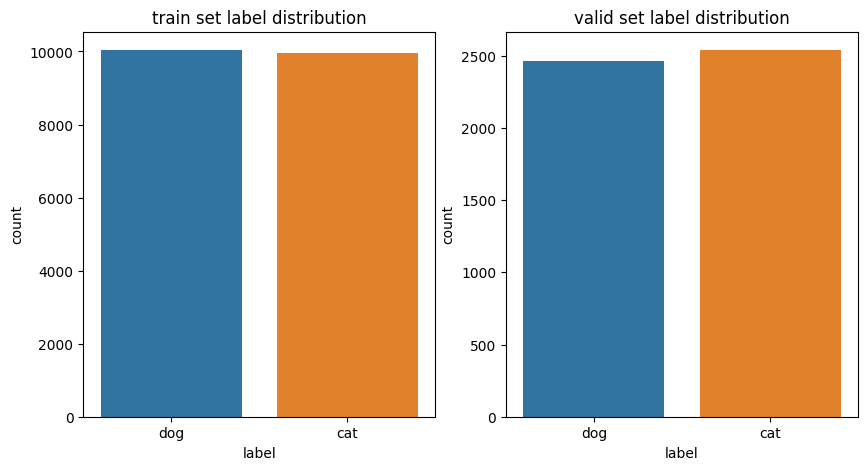

In [ ]:
print('train set distribution:\n',train_set['label'].value_counts())
print('\nvalid set distribution:\n',valid_set['label'].value_counts())
print()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x=train_set['label'], order=['dog','cat'])
plt.title('train set label distribution')

plt.subplot(1,2,2)
sns.countplot(x=valid_set['label'], order=['dog','cat'])
plt.title('valid set label distribution')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

WIDTH, HEIGHT = 150, 150
batch_size = 32

In [ ]:
train_datagenerator = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

training_data = train_datagenerator.flow_from_dataframe(dataframe=train_set,
                                                        directory='/content/train',
                                                       x_col='filename',
                                                       y_col='label',
                                                       target_size=(WIDTH, HEIGHT),
                                                       class_mode='categorical',
                                                       batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
valid_datagenerator = ImageDataGenerator(rescale=1./255)
validation_data = valid_datagenerator.flow_from_dataframe(dataframe=valid_set,
                                                         directory='/content/train',
                                                         x_col='filename',
                                                         y_col='label',
                                                         target_size=(WIDTH,HEIGHT),
                                                         class_mode='categorical',
                                                         batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import *
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential()

model.add(DefaultConv2D(filters=32, kernel_size=5, input_shape=(WIDTH, HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=64))
model.add(DefaultConv2D(filters=64))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=128))
model.add(DefaultConv2D(filters=128))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 128)       7

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', min_lr=0.00001)
checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

callbacks = [earlystop_cb, reduce_lr_cb, checkpoint_cb]

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(training_data,
                   epochs=50,
                   validation_data=validation_data,
                   validation_steps=valid_set.shape[0]//batch_size,
                   steps_per_epoch=train_set.shape[0]//batch_size,
                   callbacks=callbacks)

Epoch 1/50
625/625 [==============================] - 202s 302ms/step - loss: 0.6933 - accuracy: 0.5077 - val_loss: 0.6911 - val_accuracy: 0.5447 - lr: 0.0100
Epoch 2/50
625/625 [==============================] - 186s 298ms/step - loss: 0.6911 - accuracy: 0.5282 - val_loss: 0.6854 - val_accuracy: 0.5785 - lr: 0.0100
Epoch 3/50
625/625 [==============================] - 191s 305ms/step - loss: 0.6763 - accuracy: 0.5743 - val_loss: 0.6349 - val_accuracy: 0.6554 - lr: 0.0100
Epoch 4/50
625/625 [==============================] - 185s 296ms/step - loss: 0.6560 - accuracy: 0.6130 - val_loss: 0.6319 - val_accuracy: 0.6607 - lr: 0.0100
Epoch 5/50
625/625 [==============================] - 184s 294ms/step - loss: 0.6148 - accuracy: 0.6661 - val_loss: 0.5844 - val_accuracy: 0.6937 - lr: 0.0100
Epoch 6/50
625/625 [==============================] - 185s 296ms/step - loss: 0.5804 - accuracy: 0.6979 - val_loss: 0.5058 - val_accuracy: 0.7528 - lr: 0.0100
Epoch 7/50
625/625 [==========================

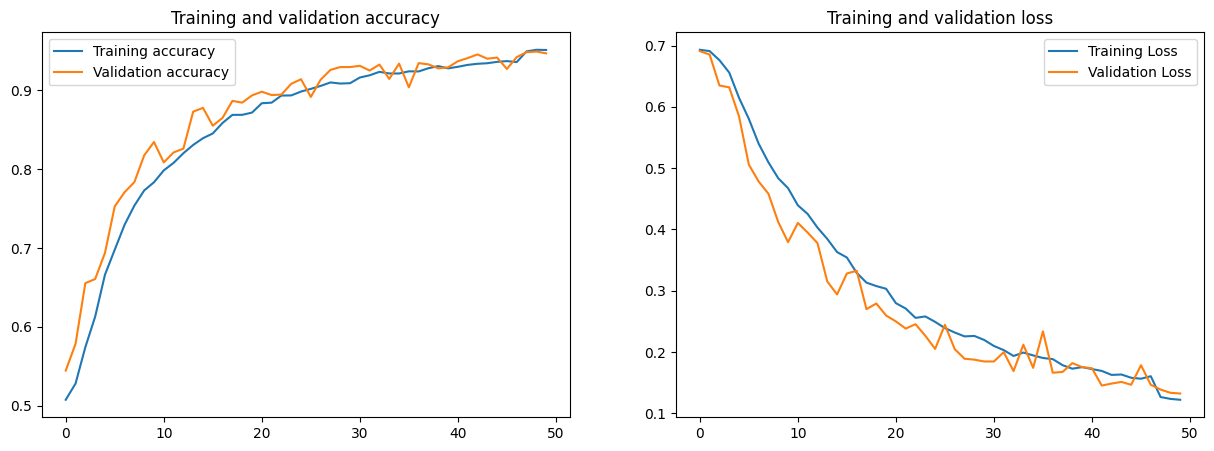

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model1 = keras.models.load_model('/content/model.h5')

In [ ]:
test_loss, test_acc = model1.evaluate(validation_data, steps=len(validation_data), verbose=1)
print('Loss: %.3f' % (test_loss))
print('Accuracy: %.3f' % (test_acc * 100.0))

In [ ]:
sampleSubmission = pd.read_csv('/content/sampleSubmission.csv')
test_df = sampleSubmission.copy()
test_df['id'] = test_df['id'].apply(lambda x : str(x)+'.png')

In [ ]:
!unzip test.zip
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(test_df,
                                                "/content/test/",
                                                x_col='id',
                                                y_col=None,
                                                class_mode=None,
                                                target_size=(WIDTH,HEIGHT),
                                                batch_size=batch_size,
                                                shuffle=False)

Archive:  test.zip
  inflating: test/1.png              
  inflating: test/10.png             
  inflating: test/2.png              
  inflating: test/3.png              
  inflating: test/4.png              
  inflating: test/5.png              
  inflating: test/6.png              
  inflating: test/7.png              
  inflating: test/8.png              
  inflating: test/9.png              
Found 10 validated image filenames.


In [ ]:
predict = model1.predict(test_generator, steps=np.ceil(test_df.shape[0]/batch_size))

1/1 [==============================] - 0s 359ms/step


In [ ]:
sampleSubmission['label'] = np.argmax(predict, axis=-1)
sampleSubmission['probability'] = np.max(predict, axis=-1)
sampleSubmission.to_csv('submission.csv', index=False)

In [ ]:
sampleSubmission

,id,label,probability
0,1,1,0.959775
1,2,1,0.996009
2,3,1,0.999995
3,4,1,0.999982
4,5,1,1.000000
5,6,1,0.999668
6,7,1,0.999164
7,8,1,1.000000
8,9,1,1.000000
9,10,1,0.514052


In [ ]:
test_df['label'] = sampleSubmission['label'].replace({ 1: 'dog', 0: 'cat' })
test_df['probability'] = sampleSubmission['probability']

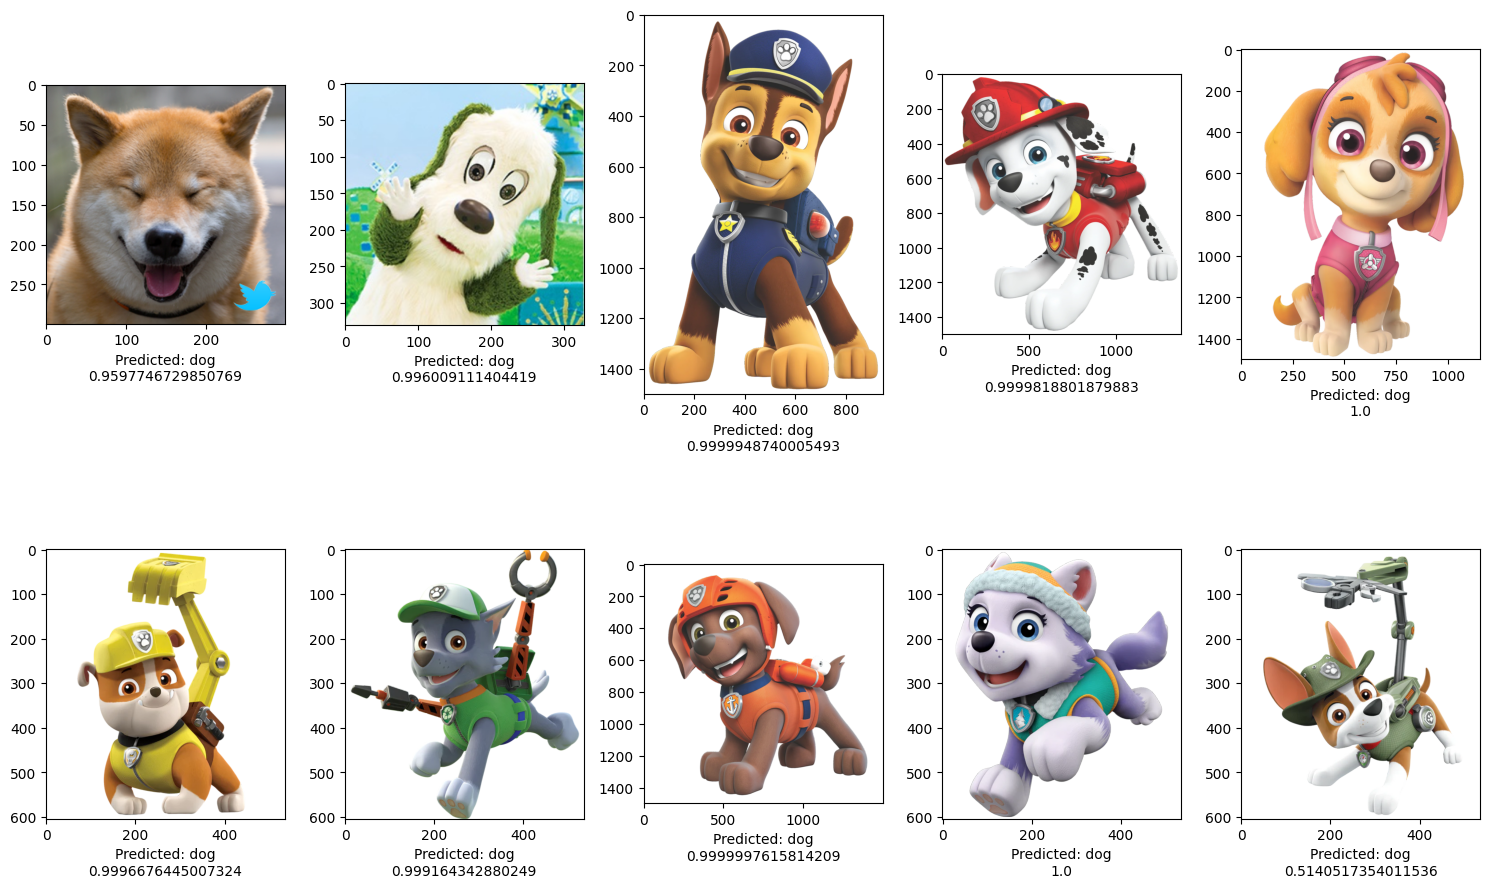

In [ ]:
sample_test = test_df.values
sample_test
plt.figure(figsize=(15, 10))
for index, row in enumerate(sample_test):
    filename = row[0]
    category = row[1]
    probability = row[2]
    image = img.imread("/content/test/"+filename)
    plt.subplot(2, 5, index+1)
    plt.imshow(image)
    # plt.xlabel('Predicted: ' + "{}".format(category) )
    plt.xlabel("Predicted: " + category + '\n' + str(probability))
plt.tight_layout()
plt.show()

In [ ]:
base_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(WIDTH,HEIGHT,3))
base_model.trainable = False ## Not trainable weights

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
from tensorflow.keras.layers import *

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(training_data,
            epochs=4,
            validation_data=validation_data,
            validation_steps=valid_set.shape[0]//batch_size,
            steps_per_epoch=train_set.shape[0]//batch_size,
            )

Epoch 1/4
625/625 [==============================] - 230s 349ms/step - loss: 0.4820 - accuracy: 0.7370 - val_loss: 0.3217 - val_accuracy: 0.8722
Epoch 2/4
625/625 [==============================] - 195s 312ms/step - loss: 0.4073 - accuracy: 0.7803 - val_loss: 0.3098 - val_accuracy: 0.8798
Epoch 3/4
625/625 [==============================] - 192s 308ms/step - loss: 0.4418 - accuracy: 0.7748 - val_loss: 0.3402 - val_accuracy: 0.8780
Epoch 4/4
625/625 [==============================] - 190s 305ms/step - loss: 0.3945 - accuracy: 0.7887 - val_loss: 0.2303 - val_accuracy: 0.9022


In [ ]:
model.layers[0].trainable=True

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 15,763,650
Trainable params: 15,763,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('model1.h5',save_best_only=True)
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(training_data,
            epochs=20,
            validation_data=validation_data,
            validation_steps=valid_set.shape[0]//batch_size,
            steps_per_epoch=train_set.shape[0]//batch_size,
            callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20
625/625 [==============================] - 235s 363ms/step - loss: 0.2771 - accuracy: 0.8419 - val_loss: 0.1007 - val_accuracy: 0.9617
Epoch 2/20
625/625 [==============================] - 222s 355ms/step - loss: 0.1960 - accuracy: 0.8978 - val_loss: 0.0723 - val_accuracy: 0.9718
Epoch 3/20
625/625 [==============================] - 226s 361ms/step - loss: 0.1104 - accuracy: 0.9556 - val_loss: 0.0663 - val_accuracy: 0.9750
Epoch 4/20
625/625 [==============================] - 225s 360ms/step - loss: 0.0875 - accuracy: 0.9659 - val_loss: 0.0877 - val_accuracy: 0.9690
Epoch 5/20
625/625 [==============================] - 222s 354ms/step - loss: 0.0713 - accuracy: 0.9733 - val_loss: 0.0779 - val_accuracy: 0.9683
Epoch 6/20
625/625 [==============================] - 226s 361ms/step - loss: 0.0563 - accuracy: 0.9792 - val_loss: 0.0612 - val_accuracy: 0.9792
Epoch 7/20
625/625 [==============================] - 226s 361ms/step - loss: 0.0471 - accuracy: 0.9823 - val_loss: 0.0743 -

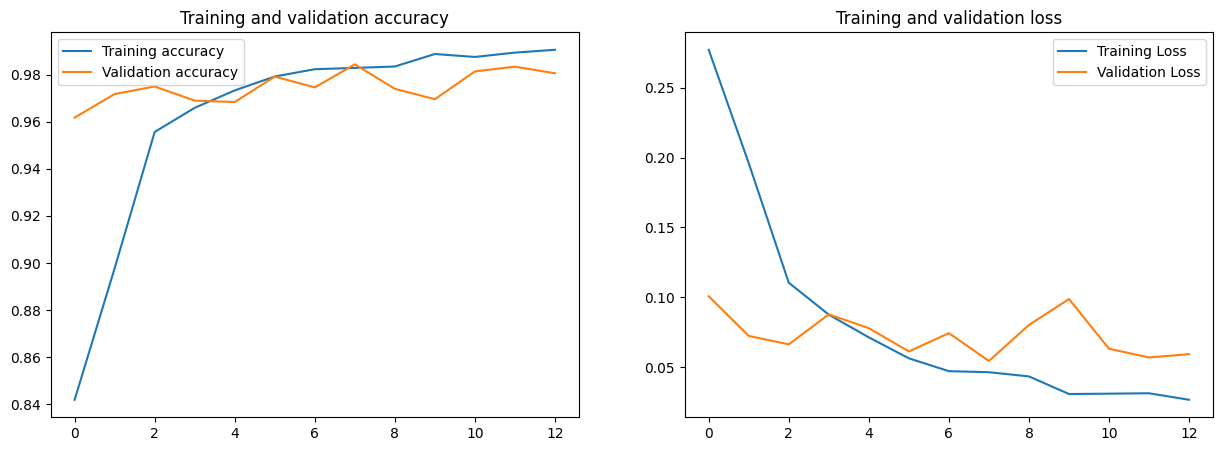

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model2 = keras.models.load_model('/content/drive/MyDrive/model1.h5')

In [ ]:
test_loss, test_acc = model2.evaluate(validation_data, steps=len(validation_data), verbose=1)
print('Loss: %.3f' % (test_loss))
print('Accuracy: %.3f' % (test_acc * 100.0))

157/157 [==============================] - 20s 125ms/step - loss: 0.0543 - accuracy: 0.9844
Loss: 0.054
Accuracy: 98.440


In [ ]:
sampleSubmission = pd.read_csv('/content/sampleSubmission.csv')
test_df = sampleSubmission.copy()
test_df['id'] = test_df['id'].apply(lambda x : str(x)+'.png')

In [ ]:
!unzip test.zip
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(test_df,
                                                "/content/test/",
                                                x_col='id',
                                                y_col=None,
                                                class_mode=None,
                                                target_size=(WIDTH,HEIGHT),
                                                batch_size=batch_size,
                                                shuffle=False)

Archive:  test.zip
  inflating: test/1.png              
  inflating: test/10.png             
  inflating: test/2.png              
  inflating: test/3.png              
  inflating: test/4.png              
  inflating: test/5.png              
  inflating: test/6.png              
  inflating: test/7.png              
  inflating: test/8.png              
  inflating: test/9.png              
Found 10 validated image filenames.


In [ ]:
predict = model2.predict(test_generator, steps=np.ceil(test_df.shape[0]/batch_size))

1/1 [==============================] - 8s 8s/step


In [ ]:
sampleSubmission['label'] = np.argmax(predict, axis=-1)
sampleSubmission['probability'] = np.max(predict, axis=-1)
sampleSubmission.to_csv('submission.csv', index=False)

In [ ]:
sampleSubmission

,id,label,probability
0,1,1,1.000000
1,2,1,0.990564
2,3,1,0.994994
3,4,1,0.998611
4,5,1,0.996037
5,6,1,0.677060
6,7,1,0.681545
7,8,1,0.999961
8,9,1,0.978053
9,10,1,0.998166


In [ ]:
test_df['label'] = sampleSubmission['label'].replace({ 1: 'dog', 0: 'cat' })
test_df['probability'] = sampleSubmission['probability']

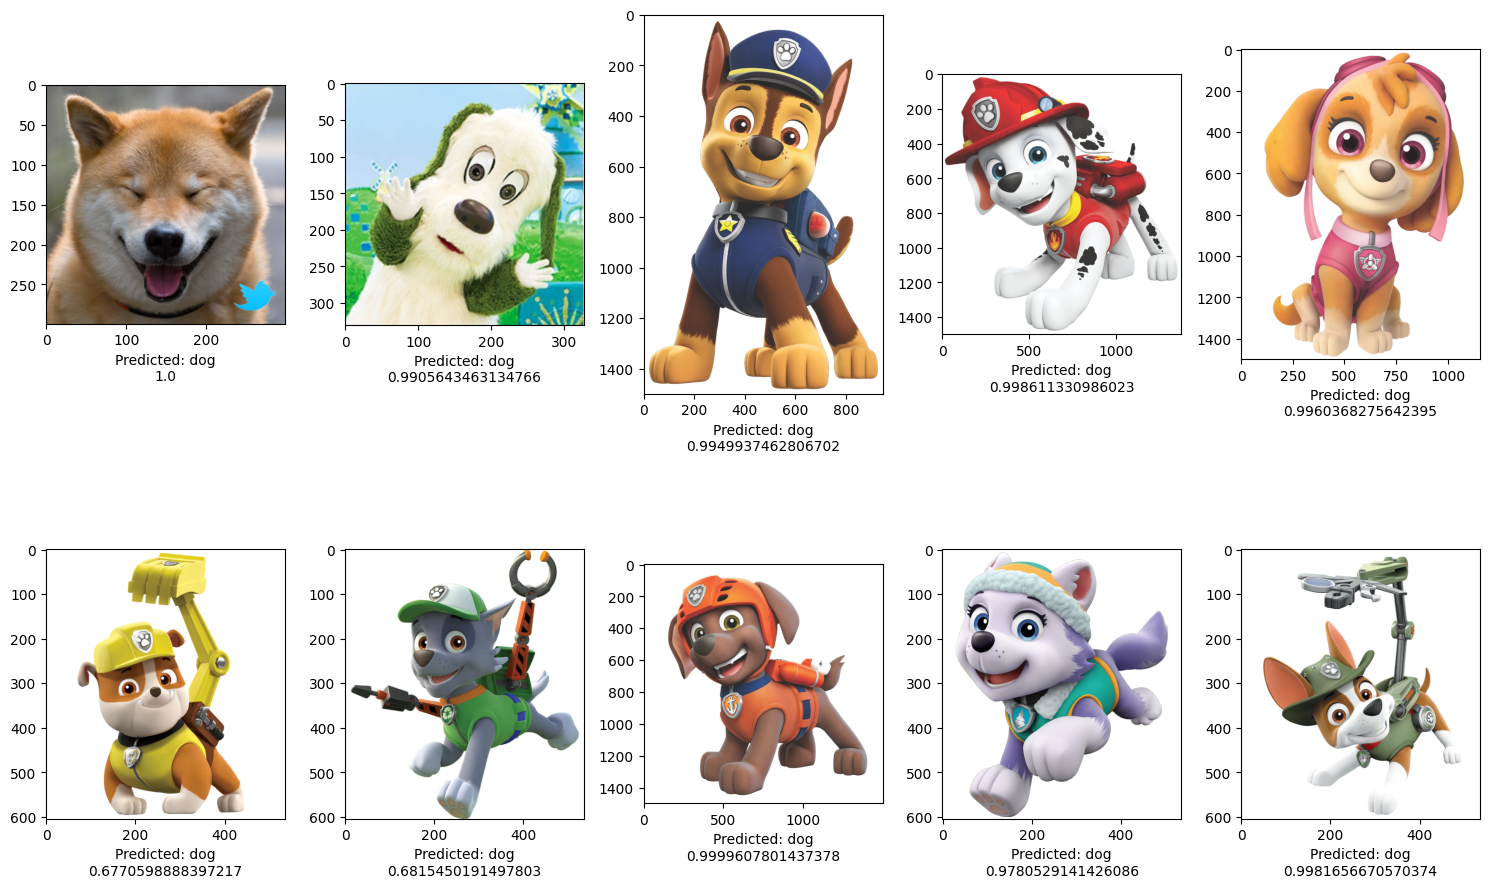

In [ ]:
sample_test = test_df.values
sample_test
plt.figure(figsize=(15, 10))
for index, row in enumerate(sample_test):
    filename = row[0]
    category = row[1]
    probability = row[2]
    image = img.imread("/content/test/"+filename)
    plt.subplot(2, 5, index+1)
    plt.imshow(image)
    # plt.xlabel('Predicted: ' + "{}".format(category) )
    plt.xlabel("Predicted: " + category + '\n' + str(probability))
plt.tight_layout()
plt.show()